In [4]:
import pandas as pd
import numpy as np
import dill
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin



1. Считаем датасет

In [5]:
train_data = pd.read_csv("train.csv")
train_data.shape

(45000, 6)

In [6]:
valid_data = pd.read_csv("valid.csv")
valid_data.shape

(15000, 6)

2. Объединим в один датасет для обработки данных

In [7]:
data = pd.concat([train_data, valid_data])
data.shape

(60000, 6)

In [8]:
data.head(5)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


3. Объединим столбцы 'Title', 'Body' в один столбец

In [9]:
data['Text']=data['Title']+' '+data['Body']
data['Text'].head(5)

0    Java: Repeat Task Every Random Seconds <p>I'm ...
1    Why are Java Optionals immutable? <p>I'd like ...
2    Text Overlay Image with Darkened Opacity React...
3    Why ternary operator in swift is so picky? <p>...
4    hide/show fab with scale animation <p>I'm usin...
Name: Text, dtype: object

4. Очистим текст 'Body' от атибутов html кода

In [10]:

from html import unescape

def delete_html_chars(text):
        parsed_text = unescape(text)
        return parsed_text

In [11]:
data['Text'] = data['Text'].apply(delete_html_chars)
data['Text'].head(9)

0    Java: Repeat Task Every Random Seconds <p>I'm ...
1    Why are Java Optionals immutable? <p>I'd like ...
2    Text Overlay Image with Darkened Opacity React...
3    Why ternary operator in swift is so picky? <p>...
4    hide/show fab with scale animation <p>I'm usin...
5    Accessing pointer member of the structure usin...
6    How To Disable 2nd Saturday 4th Saturday ,Sund...
7    Resizing containers in bootstrap I am new to b...
8    Changing Theme in Windows 10 UWP App Programma...
Name: Text, dtype: object

In [12]:
import re

def text_clean(text):
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('[^\w\s]', '',text)
    text = re.sub(r'<.*?>', '', text)
    return text

In [13]:
data['Text'] = data['Text'].apply(text_clean)

<ipython-input-12-1a3fab994556>:11: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


In [15]:
data['Text'].head(10)

0    java repeat task every random seconds pim alre...
1    why are java optionals immutable pid like to u...
2    text overlay image with darkened opacity react...
3    why ternary operator in swift is so picky pthe...
4    hideshow fab with scale animation pim using cu...
5    accessing pointer member of the structure usin...
6    how to disable nd saturday th saturday sunday ...
7    resizing containers in bootstrap i am new to b...
8    changing theme in windows  uwp app programmati...
9    textbox value disappears vb i my case i am hav...
Name: Text, dtype: object

5. Обработаем целевую переменную 'Y'


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Class']=le.fit_transform(data['Y'])

In [18]:
data['Class'].value_counts()

0    20000
1    20000
2    20000
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class', ylabel='count'>

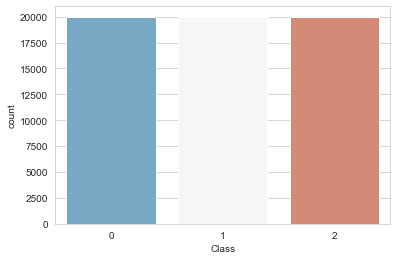

In [19]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x="Class",data=data,palette='RdBu_r')

6. Сформируем новый датасет для обучения

In [20]:
data.columns

Index(['Id', 'Title', 'Body', 'Tags', 'CreationDate', 'Y', 'Text', 'Class'], dtype='object')

In [22]:
new_data = data[['Text', 'Class']]
new_data.head(10)

,Text,Class
0,java repeat task every random seconds pim alre...,1
1,why are java optionals immutable pid like to u...,0
2,text overlay image with darkened opacity react...,0
3,why ternary operator in swift is so picky pthe...,0
4,hideshow fab with scale animation pim using cu...,0
5,accessing pointer member of the structure usin...,1
6,how to disable nd saturday th saturday sunday ...,2
7,resizing containers in bootstrap i am new to b...,2
8,changing theme in windows uwp app programmati...,0
9,textbox value disappears vb i my case i am hav...,2


7. Разделим датасет на тренировочный и тестовый

In [23]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(columns=['Class']),
                                                    new_data['Class'], random_state=0)

8. Создадим класс для отбора признаков

In [24]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


9. Создадим паплайдля обучения. (Сравним методы Случайный лес, KNN, логистическая регрессия, метод опорных векторов)

In [34]:
classifier = Pipeline([('comment_text_selector', FeatureSelector(column='Text')),
                       ('comment_text_tfidf', TfidfVectorizer(strip_accents='unicode',
                                                              analyzer='word',
                                                              token_pattern=r'\w{1,}',
                                                              stop_words='english',
                                                              max_features=5000)),
                       ('clf', RandomForestClassifier(max_depth=2, random_state=0))])

In [35]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('comment_text_selector', FeatureSelector(column='Text')),
                ('comment_text_tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english',
                                 strip_accents='unicode',
                                 token_pattern='\\w{1,}')),
                ('clf', RandomForestClassifier(max_depth=2, random_state=0))])

In [27]:
from sklearn.metrics import classification_report
pred = classifier.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      4979
           1       0.82      0.45      0.58      4991
           2       0.68      0.99      0.80      5030

    accuracy                           0.73     15000
   macro avg       0.75      0.73      0.71     15000
weighted avg       0.75      0.73      0.71     15000



In [28]:
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = Pipeline([('comment_text_selector', FeatureSelector(column='Text')),
                           ('comment_text_tfidf', TfidfVectorizer(strip_accents='unicode',
                                                              analyzer='word',
                                                              token_pattern=r'\w{1,}',
                                                              stop_words='english',
                                                              max_features=5000)),
                           ('clf', KNeighborsClassifier())])
classifier_KNN.fit(X_train, y_train)
pred_KNN = classifier_KNN.predict(X_test)
print(classification_report(y_test,pred_KNN))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      4979
           1       0.49      0.49      0.49      4991
           2       0.53      0.54      0.54      5030

    accuracy                           0.56     15000
   macro avg       0.56      0.56      0.56     15000
weighted avg       0.56      0.56      0.56     15000



In [29]:
from sklearn.linear_model import LogisticRegression
classifier_LG = Pipeline([('comment_text_selector', FeatureSelector(column='Text')),
                       ('comment_text_tfidf', TfidfVectorizer(strip_accents='unicode',
                                                              analyzer='word',
                                                              token_pattern=r'\w{1,}',
                                                              stop_words='english',
                                                              max_features=5000)),
                       ('clf', LogisticRegression(max_iter=5000))])
classifier_LG.fit(X_train, y_train)
pred_LG = classifier_LG.predict(X_test)
print(classification_report(y_test,pred_LG))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4979
           1       0.85      0.80      0.82      4991
           2       0.91      0.98      0.95      5030

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



In [33]:

from sklearn.svm import LinearSVC
classifier_SVC = Pipeline([('comment_text_selector', FeatureSelector(column='Text')),
                       ('comment_text_tfidf', TfidfVectorizer(strip_accents='unicode',
                                                              analyzer='word',
                                                              token_pattern=r'\w{1,}',
                                                              stop_words='english',
                                                              max_features=5000)),
                           ('clf', LinearSVC())])
classifier_SVC.fit(X_train, y_train)
pred_SVC = classifier_LG.predict(X_test)
print(classification_report(y_test,pred_SVC))


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4979
           1       0.85      0.80      0.82      4991
           2       0.91      0.98      0.95      5030

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



Наибольшую точность дает метод логистической регрессии и метод опорных векторов

In [36]:
pred_LG

array([1, 0, 2, ..., 1, 0, 2])